In [1]:
from robotreboot_env import RobotRebootEnv
from models.robotreboot import RobotReboot
from models.maze import Maze
from models.robotreboot import Goal
from models.instance_game import get_robot_reboot

import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
robot_reboot = get_robot_reboot()
env = RobotRebootEnv(robot_reboot)

### Deep Q-Learning

In [3]:
input_shape = env.state.shape
n_outputs = len(env.actions)
print(f'input_shape = {input_shape}\nn_outputs = {n_outputs}')

input_shape = (16, 16, 5)
n_outputs = 16


In [4]:
model = keras.models.Sequential([
    keras.layers.Conv2D(64, 4, activation='relu', padding='same', input_shape = env.state.shape),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(64, 4, activation='relu', padding='same', input_shape = env.state.shape),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(n_outputs, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        5184      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          65600     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               131200    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        5184      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          65600     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               131200    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0

In [6]:
def epsilon_greedy_policy(state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else :
        Q_values = model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

In [7]:
from collections import deque

replay_buffer = deque(maxlen=20000)

In [8]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)
    ]
    return states, actions, rewards, next_states, dones

In [9]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(env.actions[action])
    replay_buffer.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

In [10]:
batch_size = 64
discount_factor = 0.95
optimizer = keras.optimizers.Adam(lr=1e-3)
loss_fn = keras.losses.mean_squared_error

In [11]:
def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards + (1-dones) * discount_factor * max_next_Q_values)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values =tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [ ]:
dones = list()
rewards = list()
for episode in range(1000):
    obs = env.reset()
    if episode % 20 == 0:
        print(episode)
    current_reward = 0
    for step in range(100):
        epsilon = max(1 - episode/500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        current_reward += reward
        if done:
            dones.append(env.robot_reboot.current_game)
            break
        if episode > 10:
            training_step(batch_size)
    rewards.append(current_reward)

0


### Rewards plot

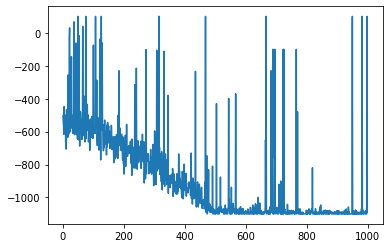

In [13]:
import matplotlib.pyplot as plt
plt.plot(rewards)
plt.show()

### Save results

In [14]:
import json
index = 0
done_games = []
for i in dones:
    state_file = f'data/done_games/state_{index}.npy'
    np.save(state_file, i.initial_state)
    done_games.append({
        "index": index,
        "state_file": state_file,
        "movements": i.movements
    })
    index += 1

In [15]:
dones_obj = {
    "robots": [i for i in env.robot_reboot.robots],
    "games": done_games
}
with open('data/done_games/result.json', 'w') as file:
    json.dump(dones_obj, file)

In [16]:
import datetime
ts = datetime.datetime.now().timestamp()
model.save(f'data/models/model-{ts}')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: data/models/model-1594484490.486487/assets


In [17]:
robot_maze = dones[0].initial_state[:, : , 1]
robot_maze

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [18]:
x, y = np.where(robot_maze == 100)

In [19]:
env.robot_reboot.state

<bound method RobotReboot.state of <models.robotreboot.RobotReboot object at 0x12267cdd0>>

In [20]:
dones[0].movements

[('R', 'S'),
 ('B', 'W'),
 ('B', 'W'),
 ('R', 'S'),
 ('G', 'W'),
 ('B', 'S'),
 ('B', 'S'),
 ('R', 'N'),
 ('R', 'N'),
 ('B', 'W'),
 ('G', 'W'),
 ('R', 'S'),
 ('G', 'E'),
 ('G', 'E'),
 ('B', 'E'),
 ('B', 'S'),
 ('R', 'W'),
 ('R', 'E'),
 ('B', 'N'),
 ('B', 'E'),
 ('B', 'W'),
 ('B', 'E'),
 ('B', 'S'),
 ('R', 'N'),
 ('B', 'S'),
 ('A', 'S'),
 ('R', 'N'),
 ('G', 'S'),
 ('B', 'E'),
 ('B', 'W'),
 ('R', 'E'),
 ('G', 'S'),
 ('R', 'E'),
 ('R', 'N'),
 ('R', 'E'),
 ('G', 'S'),
 ('A', 'W'),
 ('G', 'N'),
 ('G', 'W'),
 ('R', 'E'),
 ('G', 'S'),
 ('B', 'E'),
 ('A', 'W'),
 ('B', 'N'),
 ('G', 'N'),
 ('A', 'S'),
 ('B', 'S'),
 ('G', 'S'),
 ('G', 'N'),
 ('G', 'S'),
 ('G', 'S'),
 ('A', 'N'),
 ('B', 'N'),
 ('B', 'W'),
 ('R', 'S'),
 ('B', 'S'),
 ('R', 'N'),
 ('B', 'N'),
 ('R', 'N'),
 ('A', 'S'),
 ('R', 'S'),
 ('R', 'N'),
 ('R', 'N'),
 ('G', 'S'),
 ('R', 'E'),
 ('A', 'W'),
 ('B', 'E'),
 ('B', 'N'),
 ('R', 'S'),
 ('A', 'W'),
 ('A', 'E'),
 ('R', 'S'),
 ('R', 'W')]